##TCP Curve Fitting

###Import Data + libraries

In [222]:
import numpy as np
import pandas as pd
import os
from scipy import optimize, stats
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
#mainpath = 'C:/Users/mb22/OneDrive/PhD/Quasar Shared/' #Files are explicitely specified here and broken into 2 parts 
filepath = 'Data to Import/Prostate Outcome Summary 270515.txt' #so as to be <79 characters
#filepath = 'Data to Import/Prostate Outcome Summary 270515-2.txt'
cwd = os.getcwd()

fullpath=cwd+filepath
print(fullpath)

data = pd.read_table(filepath)
data.rename(columns={data.columns[0]: 'Study'}, inplace=True) # Rename the Study column which is unnamed int he original file

groups = data.groupby('Study')  # assign groups to the studys
data['TCP'] = data['TCP']
data # .head shows the first 5 rows of data, .tail last 5 rows

C:\Users\mb22\OneDrive\PhD\Quasar Shared\Modelling\IPythonData to Import/Prostate Outcome Summary 270515.txt


,Study,Dose,TCP
0,RT01,64,43
1,RT01,74,55
2,MD Anderson,70,43
3,MD Anderson,78,62
4,RMH,64,59
5,RMH,74,71
6,Fox Chase Low-All,69,68
7,Fox Chase Low-All,71,74
8,Fox Chase Low-All,76,69
9,Fox Chase Low-Unf,69,44


#More realistic curves to model whole population
###From Handbook fo Rad Phys

More realisitcally the TCP curves are not this steep due the variance in radiosensitivity within the population.
Nahum et al. describe how to add an additional parameter to include this within the model.
Hopefully this should give better fits to the single data sets (allowing shallower curves).
The models sums up a range of TCP fits with different weightings to produce an overall TCP fit.

page 735 in Handbook of Radiotehrapy Physics. gives the below:
(Also in paper which is mentioned in book. Sanchez-Nieto and Nahum, 1999)

$TCP = P(N,0) = e^{-N}$

$TCP = exp{-N*exp[-a*D(1+\frac{b}ad)]}$

Need to incorperate a spread in alpha (a) values

For k groups of patients each with seperate $a_i$ the value of $TCP_i$ overall is given by:

$\sum_{i=1}^k g_i TCP_{a_i}$ where $g_i$  of patients have $a=a_i$ and $\sum g_i =1$.

For a Gaussian distribution (lets assume this): $g_i \varpropto exp[-(a_i - a_m)^2 / 2s_a^2]$
where $s$ is the standard deviation of $a$ and $a_m$ is its mean

An alternative way to evalute the overall TCP is then:

$TCP = (1/k)\sum_{i=1}^k exp(-N(i))$

where $N(i) = Nexp(-a_i D)$ and N is the initial number of cells taken to be $pV$ where $p=10^7 cm^{-3}$ and $V$ is the tumour volume in $cm^3$

Combining gives:

$TCP = (1/k) \sum_{i=1}^k exp[-pVexp(-a_i D)]$

setting the SD of alpha gives the usual steep TCP curves

##Can just model using info from ESTRO presentation (Gamma fit)
###This uses gamma50 and d50 to fit a model which is a better fit to population data
Based on Bentzens paper. gives 3 different forms of model to use.

$TCP = 1/(1+exp[4g_{50}(1-D/_{D50})])$ is logistic model

[  0.84249201  69.84151855]
Trial, Gamma50, D50, Gamma74
RT01:  0.842492013229 69.8415185526 1.20133630471


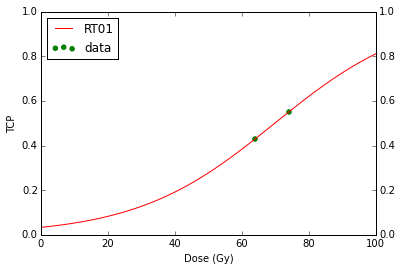

In [490]:
sub_data = data[data['Study'].isin(['RT01'])]
#sub_data = data[data['Study'].isin(['MD Anderson'])]
#sub_data = data[data['Study'].isin(['RMH'])]
#sub_data = data[data['Study'].isin(['Fox Chase Med'])]

x_data = sub_data['Dose']
y_data = 0.01*sub_data['TCP']
#print(x_data)

#x_data = data.Dose
#y_data = 0.01*data.TCP

def fitfunc(p):                      #define TCP function to fit
    TCP = 1/(1+np.exp(4*(p[0]*(1-(x_data/p[1])))))
    return TCP

## returns the sum of squares of the fitting function
def fun(p):
    return sum((y_data-fitfunc(p))**2)

#Initial guess of parameters
guess = np.array([1.0,60.0])
bnds = ((0.3, 10), (30, 100)) # Force parameters to be positive

res = optimize.minimize(fun, guess, method='SLSQP', tol=1e-10, bounds=bnds)
print(res.x)

x_fit = np.linspace(0.0, 100, 100)
yfit = 1/(1+np.exp(4*(res.x[0]*(1-(x_fit/res.x[1])))))


fig, ax1 = plt.subplots()
#fig.suptitle(sub_data['Study'][0]) # title taken from study label
ax1.scatter(x_data,y_data, color='green', label = 'data')
ax1.plot(x_fit,yfit, color='red', label = sub_data['Study'][0])
ax1.set_xlabel('Dose (Gy)')
ax1.set_ylabel('TCP')
ax1.set_ylim(0,1)
ax1.set_xlim(0,100)

ax2 = ax1.twinx()
#ax2.plot(x_fit,np.gradient(yfit, 100/len(x_fit)), color='red', ls='dashed', label='Gradient of fit')
#ax2.set_ylabel('Gradient (dTCP/dGy)')
#ax2.set_ylim(0,1)
#ax2.set_xlim(0,100)

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

g = 100*np.gradient(yfit, 100/len(x_fit))
g74=g[74]

print("Trial, Gamma50, D50, Gamma74")
print("RT01: ", res.x[0], res.x[1], g74)

#savename = 'Curve_Fits/SingleCurve.png'
#plt.savefig(savename, bbox_inches='tight', dpi=300)

##Poisson for fitting so it goes through zero...

Fit, Gamma50/37, D50/37, Gamma74
Logistic:  0.842492013229 69.8415185526 1.20133630471
Poisson:  0.749407591105 59.0802153444 1.13307276627


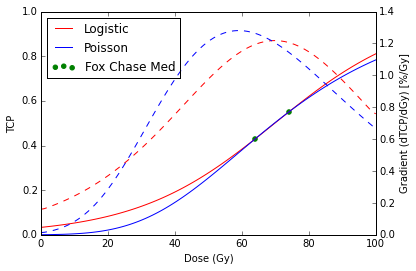

In [528]:
data_label = 'RT01' #RT01, RMH, MD Anderson, Fox Chase Low-All, Fox Chase Low-Unf, Fox Chase Med, Fox Chase High

sub_data = data[data['Study'].isin([data_label])] #get a particular studies data

x_data = sub_data['Dose']
y_data = 0.01*sub_data['TCP']

def fitfunc(p):                      #define TCP function to fit - Logistic
    TCP = 1/(1+np.exp(4*(p[0]*(1-(x_data/p[1])))))
    return TCP

## returns the sum of squares of the fitting function
def fun(p):
    return sum((y_data-fitfunc(p))**2)

def fitfunc2(q):                      #define TCP function to fit - Poisson
    #TCP = 1/(1+np.exp(4*(p[0]*(1-(x_data/p[1])))))
    TCP = np.exp(-np.exp(np.exp(1)*q[0]*(1-(x_data/q[1]))))
    return TCP

## returns the sum of squares of the fitting function
def fun2(q):
    return sum((y_data-fitfunc2(q))**2)

#Initial guess of parameters
guess = np.array([1.0,60.0])
bnds = ((0.3, 10), (30, 100)) # Force parameters to be positive

res = optimize.minimize(fun, guess, method='SLSQP', tol=1e-10, bounds=bnds)
#print(res.x)

x_fit = np.linspace(0.0, 100, 100)
yfit = 1/(1+np.exp(4*(res.x[0]*(1-(x_fit/res.x[1])))))

res3 = optimize.minimize(fun2, guess, method='SLSQP', tol=1e-10, bounds=bnds)
#print(res3.x)

x_fit2 = np.linspace(0.0, 100, 100)
yfit2 = np.exp(-np.exp(np.exp(1)*res3.x[0]*(1-(x_fit/res3.x[1]))))

fig, ax1 = plt.subplots()
ax1.scatter(x_data,y_data, color='green', label = data_label)
ax1.plot(x_fit,yfit, color='red', label = 'Logistic')
ax1.plot(x_fit,yfit2,color='blue', label = 'Poisson')
ax1.set_xlabel('Dose (Gy)')
ax1.set_ylabel('TCP')
ax1.set_ylim(0,1)
ax1.set_xlim(0,100)

ax2 = ax1.twinx()
ax2.plot(x_fit,100*np.gradient(yfit, 100/len(x_fit)), color='red', ls='dashed')
ax2.plot(x_fit,100*np.gradient(yfit2, 100/len(x_fit)), color='blue', ls='dashed')
ax2.legend(lines + lines2, labels + labels2, loc='upper left')
ax2.set_ylabel('Gradient (dTCP/dGy) [%/Gy]')
#ax2.set_ylim(0,1)
ax2.set_xlim(0,100)

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

g = 100*np.gradient(yfit, 100/len(x_fit))
g2 = 100*np.gradient(yfit2, 100/len(x_fit))
g74=g[74]
g74_2=g2[74]

print("Fit, Gamma50/37, D50/37, Gamma74")
print("Logistic: ", res.x[0], res.x[1], g74)
print("Poisson: ", res3.x[0], res3.x[1], g74_2)

###Now extract 10 points from the fitted curve to then fit an a/b fit to this

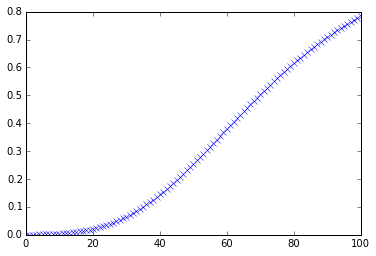

In [530]:
# create x array for points to pick
xnew=np.linspace(0,100,101)
xnew

# get y values at points in x array form fit equation
ynew = np.exp(-np.exp(np.exp(1)*res3.x[0]*(1-(xnew/res3.x[1])))) #there should be a way fo defining the function and reusing it with generic values

plt.plot(xnew,ynew, 'x') # demonstrate that the points are correct.

##Fit gamma model to it as a test...

$TCP = exp{-N*exp[-a*D(1+\frac{b}ad)]}$

'a' will have to be a spread of values

[  0.84249201  69.84151855]


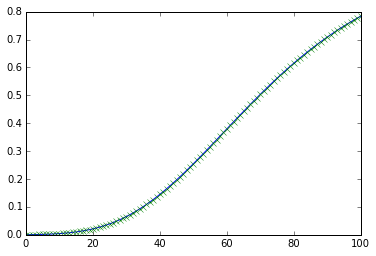

In [533]:
res1 = optimize.minimize(fun, guess, method='SLSQP', tol=1e-10, bounds=bnds)
print(res1.x)

xfit1 = np.linspace(0.0, 100, 100)
yfit1 = np.exp(-np.exp(np.exp(1)*res3.x[0]*(1-(xfit1/res3.x[1]))))

plt.plot(xfit1, yfit1)
plt.plot(xnew,ynew, 'x')

###Now create and fit alpha/beta model to fit
- Assume N etc?
- Or just assume good starting values to allow better fit?

####Plot assuming single value of alpha to get approx starting values
Parameters determined through trial and error

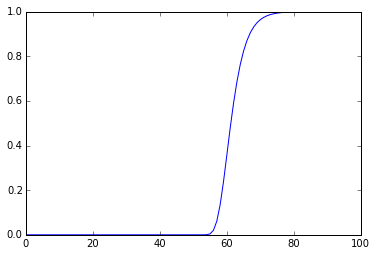

In [494]:
dens = 1E7 # clonogen density = cells per cm3
vol = 50 # prostate volume = cm3
N = dens*vol # Number of clonogens in prostate

alpha = 0.2
d = 2 # dose per fraction
Dtot = np.linspace(0.0, 100, 101) # number of fractions given (i.e. x value)
alphabeta =3 # alpha beta ratio

TCPab = np.exp(-N*np.exp(-alpha*Dtot*(1+(d/alphabeta))))
plt.plot(Dtot,TCPab)

###Now want to have a spread of alpha values in the model

$TCP = \sum(g_i TCP(a_i))$

$g_i = k exp(-(a_i-a_{mean})^2 / 2 a_{sd}^2)$

$\sum(g_i)=1$

- So need an array with a number of alpha values.
- Also need corresponding g values (which match the alpha values)
    - This will allow calc of each curve with a weighting factor
    - g values are calucalted from the alpha values
- Then sum all together.

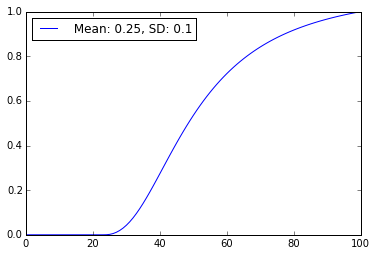

In [495]:
alpha_mean = 0.25
alpha_sd = 0.1

# array containing alpha values
alpha_i = np.linspace(0.0,0.5,101) # set the range of alphas included

#calculate probability of each alpha value
alpha_prob = stats.norm(alpha_mean,alpha_sd).pdf(alpha_i)
#plt.plot(alpha_i,alpha_prob)

#calculate TCP for each alpha_i and multiply by corresponding g_i >> use loop to do this?

dens = 1E8 # clonogen density = cells per cm3
vol = 10 # prostate volume = cm3
N = dens*vol # Number of clonogens in prostate

d = 2 # dose per fraction
Dtot = np.linspace(0.0, 100, 101) # total dose given (i.e. x value)
alphabeta =3 # alpha beta ratio
#beta = 0 # could be set for simplicity(would remove a part of the equation), but then dont have an alpha beta ratio...

#Calculate TCPs for each alpha_i and store in array
TCPall = []
for i in alpha_i:
    TCPab_i = np.exp(-N*np.exp(-i*Dtot*(1+(d/alphabeta))))
    TCPall.append(TCPab_i)

# weight each TCP absed on alpha_prob
TCPall_weighted = TCPall*alpha_prob
#plt.plot(Dtot,TCPall_weighted)

# take mean of all weighted TCPs
TCPall_weighted_mean = np.mean(TCPall_weighted, axis=1) #axis argument = 1 for rows, 0 for cols

#normalise absed on max of weighed mean TCP
TCPall_weighted_mean_norm = TCPall_weighted_mean/max(TCPall_weighted_mean)

TCPfinal = TCPall_weighted_mean_norm
#print(TCPall_weighted_mean)
plt.plot(Dtot,TCPfinal, label=' Mean: '+str(alpha_mean)+', SD: '+str(alpha_sd))
plt.legend(loc='upper left')
#print(TCPfinal)

###Simplify the above into a function

In [496]:
def TCP_ab(alpha_mean = 0.3, alpha_sd = 0.1, alphabeta = 5.0):

    ## Parameters to fit = provided to function
        #alpha_mean = 0.25
        #alpha_sd = 0.1
        #alphabeta =3 # alpha beta ratio = probably assume this

    ## Parameters assumed
    dens = 1E8 # clonogen density = cells per cm3
    vol = 10 # prostate volume = cm3
    N = dens*vol # Number of clonogens in prostate
    d = 2 # dose per fraction
    
    ##Starting dose array
    Dtot = np.linspace(0.0, 200, 101) # total dose given (i.e. x value)

    ## array containing allowed alpha values
    alpha_i = np.linspace(0.0,1,101) # set the range of alphas included

    # calculate probability of each alpha value
    alpha_prob = stats.norm(alpha_mean,alpha_sd).pdf(alpha_i)
    #plt.plot(alpha_i,alpha_prob)

    ### Calc of Overall TCP curve
    # Calculate TCPs for each alpha_i and store in array
    
    TCPall = []
    for i in alpha_i:
        TCPab_i = np.exp(-N*np.exp(-i*Dtot*(1+(d/alphabeta))))
        TCPall.append(TCPab_i)

    # weight each TCP based on alpha_prob
    TCPall_weighted = TCPall*alpha_prob
    #plt.plot(Dtot,TCPall_weighted)

    # Take mean of all weighted TCPs (no need to normalise as the alpha_prob takes care of this?)
    TCPall_weighted_mean_norm = np.mean(TCPall_weighted, axis=1) #axis argument = 1 for rows, 0 for cols
    TCPfinal = TCPall_weighted_mean_norm #copy with nicer name
    #return TCPfinal
    ###

    ## Plot graph
    plt.plot(Dtot,TCPfinal, label=' Mean: '+str(alpha_mean)+', SD: '+str(alpha_sd)+', a/b: '+str(alphabeta))
    plt.legend(loc='lower right')
    plt.xlabel('Dose')
    plt.ylabel('TCP')

In [498]:
def TCP_ab2(alpha_mean = 0.3, alpha_sd = 0.1, alphabeta = 5.0):

    ## Parameters to fit = provided to function
        #alpha_mean = 0.25
        #alpha_sd = 0.1
        #alphabeta =3 # alpha beta ratio = probably assume this

    ## Parameters assumed
    dens = 1E8 # clonogen density = cells per cm3
    vol = 10 # prostate volume = cm3
    N = dens*vol # Number of clonogens in prostate
    d = 2 # dose per fraction
    
    ##Starting dose array
    Dtot = xnew #np.linspace(0.0, 200, 101) # total dose given (i.e. x value)

    ## array containing allowed alpha values
    alpha_i = np.linspace(0.0,1,101) # set the range of alphas included

    # calculate probability of each alpha value
    alpha_prob = stats.norm(alpha_mean,alpha_sd).pdf(alpha_i)
    #plt.plot(alpha_i,alpha_prob)

    ### Calc of Overall TCP curve
    # Calculate TCPs for each alpha_i and store in array
    
    TCPall = []
    for i in alpha_i:
        TCPab_i = np.exp(-N*np.exp(-i*Dtot*(1+(d/alphabeta))))
        TCPall.append(TCPab_i)

    # weight each TCP based on alpha_prob
    TCPall_weighted = TCPall*alpha_prob
    #plt.plot(Dtot,TCPall_weighted)

    # Take mean of all weighted TCPs (no need to normalise as the alpha_prob takes care of this?)
    TCPall_weighted_mean_norm = np.mean(TCPall_weighted, axis=1) #axis argument = 1 for rows, 0 for cols
    TCPfinal = TCPall_weighted_mean_norm #copy with nicer name
    #return TCPfinal
    ###

    ## Plot graph
    plt.plot(Dtot,TCPfinal, label=' Mean: '+str(alpha_mean)+', SD: '+str(alpha_sd)+', a/b: '+str(alphabeta))
    plt.legend(loc='lower right')
    plt.xlabel('Dose')
    plt.ylabel('TCP')

###Feed parameters and plot with orig fit data

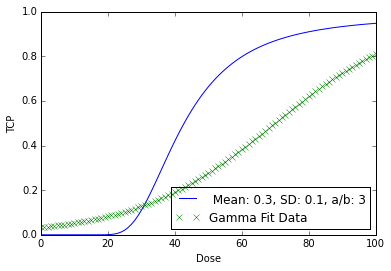

In [499]:
TCP_ab2(alpha_mean = 0.3, alpha_sd=0.1, alphabeta=3)

plt.plot(xnew,ynew,'x', label='Gamma Fit Data')
#plt.plot(Dtot,TCPfinal, label=' Mean: '+str(alpha_mean)+', SD: '+str(alpha_sd))
#plt.xlabel('Dose')
#plt.ylabel('TCP')
plt.legend(loc='lower right')

##Now want to fit the function to the data - Optimise
- Vary alpha and beta and ratio


[ 0.19210484  0.09958294  8.04924094  0.05      ]


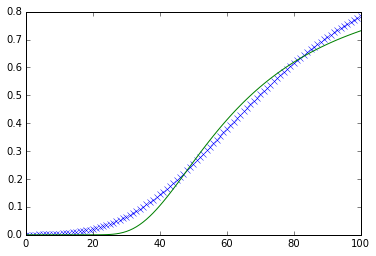

In [540]:
### Adjusted to allow variaiton of alpha etc and set bounds ready for optimisation

    ## Parameters to fit = provided to function
    #alpha_mean = 0.3
    #alpha_sd = 0.1
#alphabeta =3 # alpha beta ratio = probably assume this
        
guess_ab1 = np.array([0.3,0.1,5.0,10.0]) # alpha, alphaSD, alphabeta
bnds_ab = ((0, 10), (0.0, 0.8), (0.5, 12.0), (0.05, 100)) # Force parameters to be positive



def TCP_ab(p):
    dens = 1E8 # clonogen density = cells per cm3
    vol = p[3] # prostate volume = cm3
    N = dens*vol # Number of clonogens in prostate
    d = 2 # dose per fraction

    ##Starting dose array
    #Dtot = np.linspace(0.0, 100, 101) # total dose given (i.e. x value)

    ## array containing allowed alpha values
    alpha_i = np.linspace(0.0,1,101) # set the range of alphas included
        
    # calculate probability of each alpha value
    alpha_prob = stats.norm(p[0],p[1]).pdf(alpha_i)
           
    TCPall = []
    for i in alpha_i:
        TCPab_i = np.exp(-N*np.exp(-i*xnew*(1+(d/p[2]))))
        TCPall.append(TCPab_i)

    # weight each TCP based on alpha_prob
    TCPall_weighted = TCPall*alpha_prob

    # Take mean of all weighted TCPs (no need to normalise as the alpha_prob takes care of this?)
    TCPall_weighted_mean_norm = np.mean(TCPall_weighted, axis=1) #axis argument = 1 for rows, 0 for cols
    TCPfinal1 = TCPall_weighted_mean_norm #copy with nicer name
    return TCPfinal1

## returns the sum of squares of the fitting function
def fun_ab(p):
    return sum((ynew-TCP_ab(p))**2)

res00 = optimize.minimize(fun_ab, guess_ab1, method='SLSQP', tol=1e-10, bounds=bnds_ab)
print(res00.x)

xfitnew = np.linspace(0,100,101)
yfitnew = TCP_ab(res00.x)

plt.plot(xnew,ynew, 'x')
plt.plot(xfitnew,yfitnew)

##Not great fits...
The gamma fit obviously does not go through zero. - So ahve used Poisson
Should this be changed first to sort this?

Do other parameters need to be varied?

Should it even be possible to fit the gamma and a/b models exactly?

In [517]:
sub_data = data[data['Study'].isin(['RT01'])]

x_data = sub_data['Dose']
y_data = 0.01*sub_data['TCP']

def fitfunc(p):                      #define TCP function to fit
    TCP = 1/(1+np.exp(4*(p[0]*(1-(x_data/p[1])))))
    return TCP

## returns the sum of squares of the fitting function
def fun(p):
    return sum((y_data-fitfunc(p))**2)

#Initial guess of parameters
guess = np.array([1.0,60.0])
bnds = ((0.3, 10), (30, 100)) # Force parameters to be positive

res = optimize.minimize(fun, guess, method='SLSQP', tol=1e-10, bounds=bnds)
print(res.x)

x_fit = np.linspace(0.0, 100, 100)
yfit = 1/(1+np.exp(4*(res.x[0]*(1-(x_fit/res.x[1])))))

[  0.84249201  69.84151855]


##Put data into an array then into pandas dataframe
Ideally this should be automatic and calc for all trials within the data file...
**Automation is something to mention in confirmation report**

In [12]:
fit_data = np.array([['RT01', 0.842498337347, 69.8412098135,1.20133630471, 'None'],
                     ['RMH', 0.759297576379, 57.1513235625,1.08651400899, 'None'],
                     ['MD Anderson', 1.75790113754, 72.923021042,2.41436353966, 'None'],
                     ['Fox Chase Low-All', 0.3, 41.8541044255,0.584182231636, 'Not a good fit'],
                     ['Fox Chase Low-Unfavourable', 2.0382873516, 70.9091385132,2.76395623366, 'None'],
                     ['Fox Chase Med', 9.96748391355, 73.1852608504, 11.3881977613, 'None'],
                     ['Fox Chase High', 5.75579625646, 80.0, 0.887696792319, 'Not a good fit']])
#fit_data

In [13]:
fit_data_pd = pd.DataFrame(fit_data, columns=['Trial', 'Gamma50','D50','Gamma74', 'Comments'])
fit_data_pd

,Trial,Gamma50,D50,Gamma74,Comments
0,RT01,0.842498337347,69.8412098135,1.20133630471,None
1,RMH,0.759297576379,57.1513235625,1.08651400899,None
2,MD Anderson,1.75790113754,72.923021042,2.41436353966,None
3,Fox Chase Low-All,0.3,41.8541044255,0.584182231636,Not a good fit
4,Fox Chase Low-Unfavourable,2.0382873516,70.9091385132,2.76395623366,None
5,Fox Chase Med,9.96748391355,73.1852608504,11.3881977613,None
6,Fox Chase High,5.75579625646,80.0,0.887696792319,Not a good fit


In [14]:
# Save fit parameters to excel sheet called 'output'

from pandas import ExcelWriter
writer = ExcelWriter('output.xlsx')
fit_data_pd.to_excel(writer,'Sheet1')
writer.save()

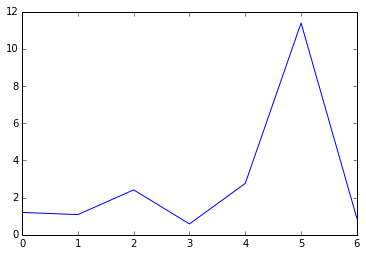

In [15]:
# Describe the G74 data and show range on graph

g74all = fit_data_pd['Gamma74'].convert_objects(convert_numeric=True)

g74all.describe()
plt.plot(g74all)


##Now try and add a Poisson model for comparison
It is expected that there will not be a huge difference, but useful for the Thesis to have this.

In [16]:
e = np.exp(1)
e

2.7182818284590451

[ 0.01       1.8264399]
Trial, Gamma37, D37, Gamma74
FC high:  0.01 1.82643990136 0.362256802799


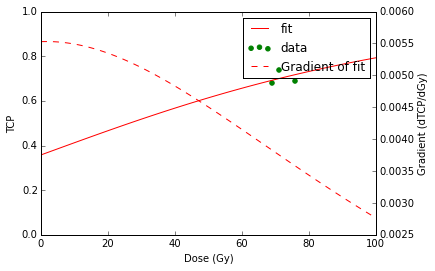

In [85]:
#sub_data = data[data['Study'].isin(['RT01'])]
#sub_data = data[data['Study'].isin(['RMH'])]
#sub_data = data[data['Study'].isin(['MD Anderson'])]
sub_data = data[data['Study'].isin(['Fox Chase Low-All'])]
#sub_data = data[data['Study'].isin(['Fox Chase Low-Unf'])]
#sub_data = data[data['Study'].isin(['Fox Chase Med'])]
#sub_data = data[data['Study'].isin(['Fox Chase High'])]

x_data = sub_data['Dose']
y_data = 0.01*sub_data['TCP']
#print(x_data)

#x_data = data.Dose
#y_data = 0.01*data.TCP

def fitfunc(p):                      #define TCP function to fit
    #TCP = 1/(1+np.exp(4*(p[0]*(1-(x_data/p[1])))))
    TCP = np.exp(-np.exp(np.exp(1)*p[0]*(1-(x_data/p[1]))))
    return TCP

## returns the sum of squares of the fitting function
def fun(p):
    return sum((y_data-fitfunc(p))**2)

#Initial guess of parameters
guess = np.array([1.0,60.0])
bnds = ((0.01, 10), (0, 100)) # Force parameters to be positive

#res = optimize.minimize(fun, guess, method='SLSQP', tol=1e-10, bounds=bnds)
res = optimize.minimize(fun, guess, method='SLSQP', tol=1e-10, bounds=bnds)
print(res.x)

x_fit = np.linspace(0.0, 100, 100)
#yfit_rt01 = 1/(1+np.exp(4*(res.x[0]*(1-(x_fit/res.x[1])))))
yfit_rt01 = np.exp(-np.exp(np.exp(1)*res.x[0]*(1-(x_fit/res.x[1]))))

fig, ax1 = plt.subplots()
ax1.scatter(x_data,y_data, color='green', label = 'data')
ax1.plot(x_fit,yfit_rt01, color='red', label = 'fit')
ax1.set_xlabel('Dose (Gy)')
ax1.set_ylabel('TCP')
ax1.set_ylim(0,1)
ax1.set_xlim(0,100)

ax2 = ax1.twinx()
ax2.plot(x_fit,np.gradient(yfit_rt01, 100/len(x_fit)), color='red', ls='dashed', label='Gradient of fit')
ax2.set_ylabel('Gradient (dTCP/dGy)')
#ax2.set_ylim(0,1)
ax2.set_xlim(0,100)

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='best')

g = 100*np.gradient(yfit_rt01, 100/len(x_fit))
g74=g[74]

print("Trial, Gamma37, D37, Gamma74")
print("FC high: ", res.x[0], res.x[1], g74)


In [8]:
fit_data_p = np.array([['RT01', 0.749407591105, 59.0802153444, 1.13307276627, 'None'],
                     ['RMH', 0.782253891558, 49.205192106, 1.03901419754, 'None'],
                     ['MD Anderson', 0.76729939103, 67.6123804217, 2.36603250256, 'None'],
                     ['Fox Chase Low-All', 0.01, 1.82643990136, 0.362256802799, 'Not a good fit'],
                     ['Fox Chase Low-Unfavourable', 2.12122701618, 66.6069492601, 2.635667343, 'None'],
                     ['Fox Chase Med', 9.66691443532, 71.9494967904, 9.27248294077, 'None'],
                     ['Fox Chase High', 0.921244324034, 100.0, 0.724845431216, 'Not a good fit']])
#fit_data_p

fit_data_p_pd = pd.DataFrame(fit_data_p, columns=['Trial', 'Gamma37','D37','Gamma74', 'Comments'])
fit_data_p_pd

,Trial,Gamma37,D37,Gamma74,Comments
0,RT01,0.749407591105,59.0802153444,1.13307276627,None
1,RMH,0.782253891558,49.205192106,1.03901419754,None
2,MD Anderson,0.76729939103,67.6123804217,2.36603250256,None
3,Fox Chase Low-All,0.01,1.82643990136,0.362256802799,Not a good fit
4,Fox Chase Low-Unfavourable,2.12122701618,66.6069492601,2.635667343,None
5,Fox Chase Med,9.66691443532,71.9494967904,9.27248294077,None
6,Fox Chase High,0.921244324034,100.0,0.724845431216,Not a good fit


In [9]:
# Save fit parameters to excel sheet called 'output'

from pandas import ExcelWriter
writer = ExcelWriter('output.xlsx')
fit_data_p_pd.to_excel(writer,'Sheet1')
writer.save()

###Want to plot graph with all fits...
- Start a new notebook with these fits now they work.
- Want to make them into better functions eventually...

#####Also do weighted least squares (weighted by a factor derived from the error on each point).


Least squares minimisation: $\sum_{i=1}^n (y - y_{fit})^2$

Weighted Least squares minimisation: $\sum_{i=1}^n w_i(y - y_{fit})^2$ where $w_i$ is a weighting factor for each point

If use SD as the error, then the weighting factor is 1/SD (larger error = smaller weighting).
Obviously this doesn't do anything if there is only 2 points which is the case most of the time.

constraints can be used to restrict a>0, b>0, a/b > 1 etc. e.g. x[0] > 0, x[0]/x[1] > 1
This is in place of bounds which limit the values to between certain numbers as above. (min,max)


######Says one minus the sum of all variables must be zero
cons = ({'type': 'eq', 'fun': lambda x:  1 - sum(x)})               #this says that 1-sum(all aprams)=0 ('eq' = 0) Can only set = 0 or not=0 [in

######Required to have non negative values
bnds = tuple((0,None) for x in start_pos)         #if just want all vals to be positive could do this

http://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html shows example

In [20]:
>>> cons = ({'type': 'eq',
...          'fun' : lambda x: np.array([x[0]**3 - x[1]]),               #(x^3 - y = 0)
...          'jac' : lambda x: np.array([3.0*(x[0]**2.0), -1.0])},
...         {'type': 'ineq',
...          'fun' : lambda x: np.array([x[1] - 1]),                      #(y - 1 = 0)
...          'jac' : lambda x: np.array([0.0, 1.0])})

##Now plot logistic + Poisson on same graph

Fit, Gamma50/37, D50/37, Gamma74
Logistic:  9.96743999802 73.1852653906 11.3881977613
Poisson:  9.66691443532 71.9494967904 9.27248294077


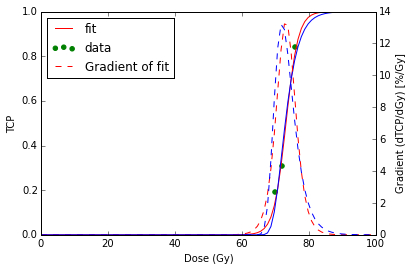

In [56]:
data_label = 'Fox Chase Med' #RT01, RMH, MD Anderson, Fox Chase Low-All, Fox Chase Low-Unf, Fox Chase Med, Fox Chase High

sub_data = data[data['Study'].isin([data_label])] #get a particular studies data

x_data = sub_data['Dose']
y_data = 0.01*sub_data['TCP']

def fitfunc(p):                      #define TCP function to fit - Logistic
    TCP = 1/(1+np.exp(4*(p[0]*(1-(x_data/p[1])))))
    return TCP

## returns the sum of squares of the fitting function
def fun(p):
    return sum((y_data-fitfunc(p))**2)

def fitfunc2(q):                      #define TCP function to fit - Poisson
    #TCP = 1/(1+np.exp(4*(p[0]*(1-(x_data/p[1])))))
    TCP = np.exp(-np.exp(np.exp(1)*q[0]*(1-(x_data/q[1]))))
    return TCP

## returns the sum of squares of the fitting function
def fun2(q):
    return sum((y_data-fitfunc2(q))**2)

#Initial guess of parameters
guess = np.array([1.0,60.0])
bnds = ((0.3, 10), (30, 100)) # Force parameters to be positive

res = optimize.minimize(fun, guess, method='SLSQP', tol=1e-10, bounds=bnds)
#print(res.x)

x_fit = np.linspace(0.0, 100, 100)
yfit = 1/(1+np.exp(4*(res.x[0]*(1-(x_fit/res.x[1])))))

res3 = optimize.minimize(fun2, guess, method='SLSQP', tol=1e-10, bounds=bnds)
#print(res3.x)

x_fit2 = np.linspace(0.0, 100, 100)
yfit2 = np.exp(-np.exp(np.exp(1)*res3.x[0]*(1-(x_fit/res3.x[1]))))

fig, ax1 = plt.subplots()
ax1.scatter(x_data,y_data, color='green', label = data_label)
ax1.plot(x_fit,yfit, color='red', label = 'Logistic')
ax1.plot(x_fit,yfit2,color='blue', label = 'Poisson')
ax1.set_xlabel('Dose (Gy)')
ax1.set_ylabel('TCP')
ax1.set_ylim(0,1)
ax1.set_xlim(0,100)

ax2 = ax1.twinx()
ax2.plot(x_fit,100*np.gradient(yfit, 100/len(x_fit)), color='red', ls='dashed')
ax2.plot(x_fit,100*np.gradient(yfit2, 100/len(x_fit)), color='blue', ls='dashed')
ax2.legend(lines + lines2, labels + labels2, loc='upper left')
ax2.set_ylabel('Gradient (dTCP/dGy) [%/Gy]')
#ax2.set_ylim(0,1)
ax2.set_xlim(0,100)

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

g = 100*np.gradient(yfit, 100/len(x_fit))
g2 = 100*np.gradient(yfit2, 100/len(x_fit))
g74=g[74]
g74_2=g2[74]

print("Fit, Gamma50/37, D50/37, Gamma74")
print("Logistic: ", res.x[0], res.x[1], g74)
print("Poisson: ", res3.x[0], res3.x[1], g74_2)

#savename = 'Curve_Fits/'+data_label+'.png'
#plt.savefig(savename, bbox_inches='tight', dpi=300)


###All plots on same graph using loop

In [43]:
data_labels = ['RT01', 'RMH', 'MD Anderson', 'Fox Chase Low-All',
               'Fox Chase Low-Unf', 'Fox Chase Med', 'Fox Chase High']
for data in  data_labels:
    data_label = data
    print(data_label)

RT01
RMH
MD Anderson
Fox Chase Low-All
Fox Chase Low-Unf
Fox Chase Med
Fox Chase High
test


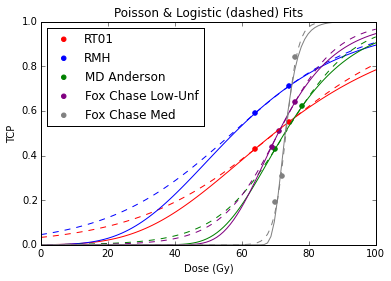

In [100]:
def fitfunc(p):                      #define TCP function to fit - Logistic
    TCP = 1/(1+np.exp(4*(p[0]*(1-(x_data/p[1])))))
    return TCP

## returns the sum of squares of the fitting function
def fun(p):
    return sum((y_data-fitfunc(p))**2)

def fitfunc2(q):                      #define TCP function to fit - Poisson
    #TCP = 1/(1+np.exp(4*(p[0]*(1-(x_data/p[1])))))
    TCP = np.exp(-np.exp(np.exp(1)*q[0]*(1-(x_data/q[1]))))
    return TCP

## returns the sum of squares of the fitting function
def fun2(q):
    return sum((y_data-fitfunc2(q))**2)

##Create figure to plot on
fig, ax1 = plt.subplots()

data_labels_all = ['RT01', 'RMH', 'MD Anderson', 'Fox Chase Low-All',
               'Fox Chase Low-Unf', 'Fox Chase Med', 'Fox Chase High']
data_labels_fitted = ['RT01', 'RMH', 'MD Anderson',
               'Fox Chase Low-Unf', 'Fox Chase Med']
data_colors = ['red', 'blue', 'green', 'orange',
               'purple', 'grey', 'yellow']

for data_name in  data_labels_fitted:
    data_label = data_name
    #print(data_label)
    #print(data_labels.index(data_name))
    plot_col = data_colors[data_labels.index(data_name)]
    #print(plot_col)
    
    #data_label = 'Fox Chase Med'
    
    sub_data = data[data['Study'].isin([data_label])] #get a particular studies data

    x_data = sub_data['Dose']
    y_data = 0.01*sub_data['TCP']

    #Initial guess of parameters
    guess = np.array([1.0,60.0])
    bnds = ((0.3, 10), (30, 100)) # Force parameters to be positive

    res = optimize.minimize(fun, guess, method='SLSQP', tol=1e-10, bounds=bnds)
    #print(res.x)

    x_fit = np.linspace(0.0, 100, 100)
    yfit = 1/(1+np.exp(4*(res.x[0]*(1-(x_fit/res.x[1])))))

    res3 = optimize.minimize(fun2, guess, method='SLSQP', tol=1e-10, bounds=bnds)
    #print(res3.x)

    ax1.scatter(x_data,y_data, color=plot_col, label = data_label)
    
    x_fit2 = np.linspace(0.0, 100, 100)
    yfit2 = np.exp(-np.exp(np.exp(1)*res3.x[0]*(1-(x_fit/res3.x[1]))))

##yfit is Logistic, yfit2 is Poisson.

    #ax1.plot(x_fit,yfit, color=plot_col, label = 'Logistic')
    #ax1.plot(x_fit,yfit2,color=plot_col, label = 'Poisson')
    
    ax1.plot(x_fit,yfit, color=plot_col, ls='--') #Labels removed for plot of all with coloured lines
    ax1.plot(x_fit,yfit2,color=plot_col)
    
    ax1.set_xlabel('Dose (Gy)')
    ax1.set_ylabel('TCP')
    ax1.set_ylim(0,1)
    ax1.set_xlim(0,100)
    #ax1.legend()

    ## Second y axis for gradients to be scaled
    #ax2 = ax1.twinx()
    #ax2.plot(x_fit,100*np.gradient(yfit, 100/len(x_fit)), color='red', ls='dashed')
    #ax2.plot(x_fit,100*np.gradient(yfit2, 100/len(x_fit)), color='blue', ls='dashed')
    #ax2.legend(lines + lines2, labels + labels2, loc='upper left')
    #ax2.set_ylabel('Gradient (dTCP/dGy) [%/Gy]')
    #ax2.set_ylim(0,1)
    #ax2.set_xlim(0,100)

    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()

    g = 100*np.gradient(yfit, 100/len(x_fit))
    g2 = 100*np.gradient(yfit2, 100/len(x_fit))
    g74=g[74]
    g74_2=g2[74]

    #print("Fit, Gamma50/37, D50/37, Gamma74")
    #print("Logistic: ", res.x[0], res.x[1], g74)
    #print("Poisson: ", res3.x[0], res3.x[1], g74_2)

ax1.legend(loc='best', scatterpoints=1)
plt.title('Poisson & Logistic (dashed) Fits')

#savename = 'Curve_Fits/Poisson+Logistic_Fits_All_Coloured_Prostate.png'
#plt.savefig(savename, bbox_inches='tight', dpi=300)


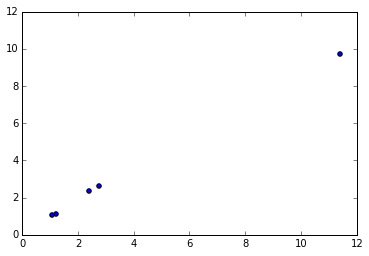

In [107]:
plt.scatter(box_data_l,box_data_p)
plt.show()

2.414 2.366


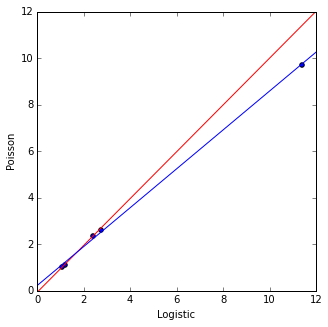

In [152]:
plt.figure(figsize=(5,5))
linfit = np.polyfit(box_data_l[0:3], box_data_p[0:3],1)
linfitall = np.polyfit(box_data_l, box_data_p,1)
xfit=np.linspace(0,12,20)
yfit= linfit[0]*xfit + linfit[1]
yfitall= linfitall[0]*xfit + linfitall[1]
plt.scatter(box_data_l, box_data_p)
plt.plot(xfit,yfit, color='red')
plt.plot(xfit,yfitall, color='blue')
plt.xlim(0,12)
plt.ylim(0,12)
plt.xlabel('Logistic')
plt.ylabel('Poisson')
#plt.show()
savename = 'Curve_Fits/PvsL_linfit_fits.png'
plt.savefig(savename, bbox_inches='tight', dpi=300)
print(np.median(box_data_l), np.median(box_data_p))

###Now plot all Poisson Results on same graph